# **Diagnóstico de Problemas Veiculares com Word2Vec**

Introdução
Este notebook explora o uso de Word2Vec para identificar problemas veiculares semelhantes em um conjunto de dados. Vamos:

Carregar e pré-processar os dados de problemas.
Dividir os dados em conjuntos de treino e teste.
Treinar um modelo Word2Vec no conjunto de treino.
Avaliar a similaridade no conjunto de teste.
Testar o modelo com uma função que encontra o problema mais semelhante para um problema de exemplo.


In [1]:
# Importação de bibliotecas
import pandas as pd
import re
import unicodedata
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity



---


##**1. Carregar e Visualizar o Dataset**

### **Importação do dataset**

Aqui vamos importar o dataset para realizar a análise e desenvolver o modelo de IA

In [2]:
# Carregar o dataset
file_path = '/content/diagnostico_problemas_veicular.csv'
df = pd.read_csv(file_path, sep=",")

# Exibir as primeiras linhas do dataset
df.head()


,Fabricante,Modelo,Ano,Problema,Causa,Solucao,Orcamento,Categoria do Problema,Gravidade do Problema,Tempo Estimado de Reparo
0,Ford,Focus,2019,Motor fazendo ruído metálico,Filtro de combustível entupido,Limpeza e troca do filtro,1882,Freios,Média,2.9
1,Fiat,Mobi,2022,Falha no sistema de direção elétrica,Falha no sistema hidráulico,Troca da embreagem,1934,Transmissão,Baixa,3.2
2,Renault,Kwid,2018,Transmissão com falhas,Correia de direção desgastada,Substituição das válvulas,1006,Motor,Média,2.6
3,Renault,Duster,2022,Dificuldade para engatar marchas,Falta de gás refrigerante,Substituição da bateria,1131,Transmissão,Média,2.8
4,Chevrolet,S10,2018,Dificuldade para engatar marchas,Problema na embreagem,Substituição do sensor,1373,Direção,Média,1.6


### **Análise Inicial**
Vamos realizar uma análise exploratória inicial para entender melhor os dados com os quais estamos trabalhando.

In [3]:
# Análise exploratória dos dados
print("Resumo das colunas:")
df.info()

print("\nVerificar valores nulos:")
df.isnull().sum()

print("\nDistribuição das classe target:")
df['Problema'].value_counts()

Resumo das colunas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fabricante                100 non-null    object 
 1   Modelo                    100 non-null    object 
 2   Ano                       100 non-null    int64  
 3   Problema                  100 non-null    object 
 4   Causa                     100 non-null    object 
 5   Solucao                   100 non-null    object 
 6   Orcamento                 100 non-null    int64  
 7   Categoria do Problema     100 non-null    object 
 8   Gravidade do Problema     100 non-null    object 
 9   Tempo Estimado de Reparo  100 non-null    float64
dtypes: float64(1), int64(2), object(7)
memory usage: 7.9+ KB

Verificar valores nulos:

Distribuição das classe target:


,count
Problema,
Transmissão com falhas,15
Motor fazendo ruído metálico,11
Dificuldade para engatar marchas,11
Luz de injeção acesa,10
Ruído ao virar o volante,10
Falha no sistema de direção elétrica,8
Consumo elevado de combustível,8
Perda de potência em subidas,8
Luz do ABS acesa,7


In [4]:
print("\nEstatísticas descritivas de colunas categoricas:")
df.describe(include="object")


Estatísticas descritivas de colunas categoricas:


,Fabricante,Modelo,Problema,Causa,Solucao,Categoria do Problema,Gravidade do Problema
count,100,100,100,100,100,100,100
unique,7,21,12,12,12,6,3
top,Ford,Fiesta,Transmissão com falhas,Falha no sistema hidráulico,Substituição das válvulas,Motor,Média
freq,19,8,15,13,14,22,41


In [5]:
print("\nEstatísticas descritivas de colunas numericas:")
df.describe()


Estatísticas descritivas de colunas numericas:


,Ano,Orcamento,Tempo Estimado de Reparo
count,100.000000,100.000000,100.000000
mean,2019.120000,1196.760000,2.555000
std,2.610314,500.257936,0.932183
min,2015.000000,303.000000,1.000000
25%,2017.000000,742.250000,1.600000
50%,2019.000000,1203.500000,2.600000
75%,2021.000000,1633.250000,3.400000
max,2023.000000,1994.000000,4.000000


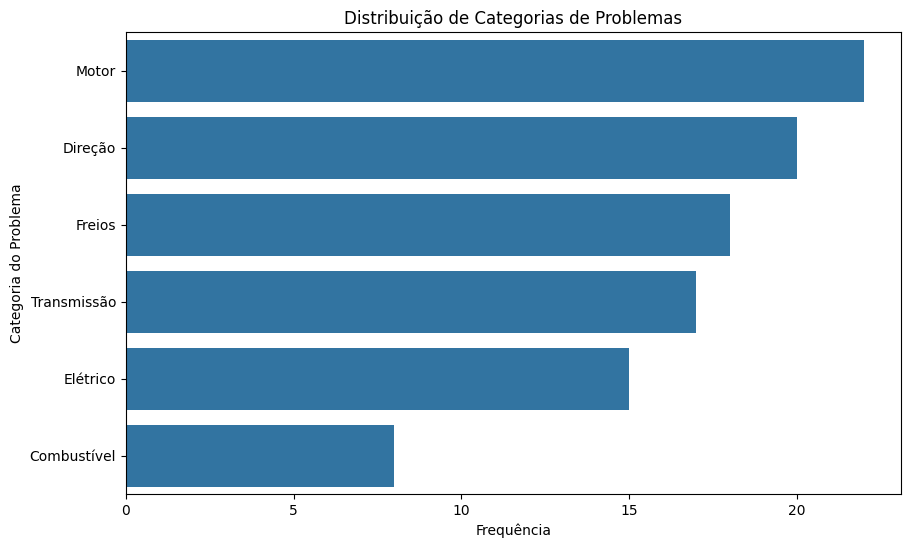

In [6]:
# Contagem de categorias de problemas para visualização
plt.figure(figsize=(10, 6))
sns.countplot(y='Categoria do Problema', data=df, order=df['Categoria do Problema'].value_counts().index)
plt.title('Distribuição de Categorias de Problemas')
plt.xlabel('Frequência')
plt.ylabel('Categoria do Problema')
plt.show()

## **2. Pré-processamento dos Dados**

### **Stopwords**

Configura stopwords em português para o pré-processamento do texto. Ou seja palavras comuns e irrelevantes que geralmente não agregam valor ao significado do texto, como "de", "a", "o", "e", "para"...

In [7]:
# Baixar e configurar stopwords em português
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Função de Pré-processamento**
Essa função realiza o pré-processamento, que inclui:
- Converter o texto para minúsculas
- Remover caracteres especiais
- Remover acentos
- Remover stopwords

O objetivo é normalizar o texto para melhor correspondência semântica.

In [8]:
# Função de Pré-processamento
def preprocess_text(text):
    # Converte para minúsculas
    text = text.lower()

    # Remove acentos
    text = ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    )

    # Remove caracteres especiais
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

teste = preprocess_text("O Carro ta fazendo barulho na Transmissão")
print(teste)

carro ta fazendo barulho transmissao


### **Divisão do Conjunto de Dados**
Dividimos os dados em conjuntos de treino e teste para garantir que não haja vazamento de informações durante o treinamento e avaliação do modelo.

In [9]:
# Dividir o dataset em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Pré-processamento para treino e teste
train_problems_processed = [preprocess_text(problem) for problem in train_df['Problema']]
test_problems_processed = [preprocess_text(problem) for problem in test_df['Problema']]
train_texts = [text.split() for text in train_problems_processed]

## **4. Treino do Modelo**
Aqui, o modelo Word2Vec é treinado usando o conjunto de problemas veiculares. Esse modelo aprende as representações de palavras com base em seu contexto, o que permite capturar a semântica do problema descrito.

### **Parâmetros determinados para o modelo**

- **sentences=train_texts:** lista de listas de palavras. Word2Vec usa essas listas para entender o contexto de cada palavra.
- **vector_size=50:** define o tamanho dos vetores de palavras.
- **window=10:** determina o tamanho da janela de contexto, ou seja, o número de palavras à esquerda e à direita da palavra-alvo.
- **min_count=2:** define o número mínimo de ocorrências de uma palavra para que ela seja incluída no vocabulário.
-  **sg=1** (1 para Skip-gram, 0 para CBOW)

In [10]:
# Treinar o modelo Word2Vec com parâmetros ajustados para captar contextos amplos e mais generalistas
model = Word2Vec(
    sentences=train_texts,    # Dados de treino
    vector_size=50,           # Tamanho do vetor menor para generalização
    window=10,                # Contexto mais amplo
    min_count=2,              # Ignorar palavras raras
    sg=1,                     # Modelo Skip-gram (1 para Skip-gram, 0 para CBOW)
)
print("Modelo Word2Vec treinado com sucesso com parâmetros ajustados!")


Modelo Word2Vec treinado com sucesso com parâmetros ajustados!


### **Salvar modelo criado**

In [20]:
# Salvar o modelo Word2Vec
model_path = '/content/word2vec_model.pkl'
model.save(model_path)
print(f'Modelo Word2Vec salvo em {model_path}')

Modelo Word2Vec salvo em /content/word2vec_model.pkl


### **Visualização das palavras selecionadas pelo modelo**
Selecionamos as palavras mais comuns e relacionadas ao contexto veicular para visualização.

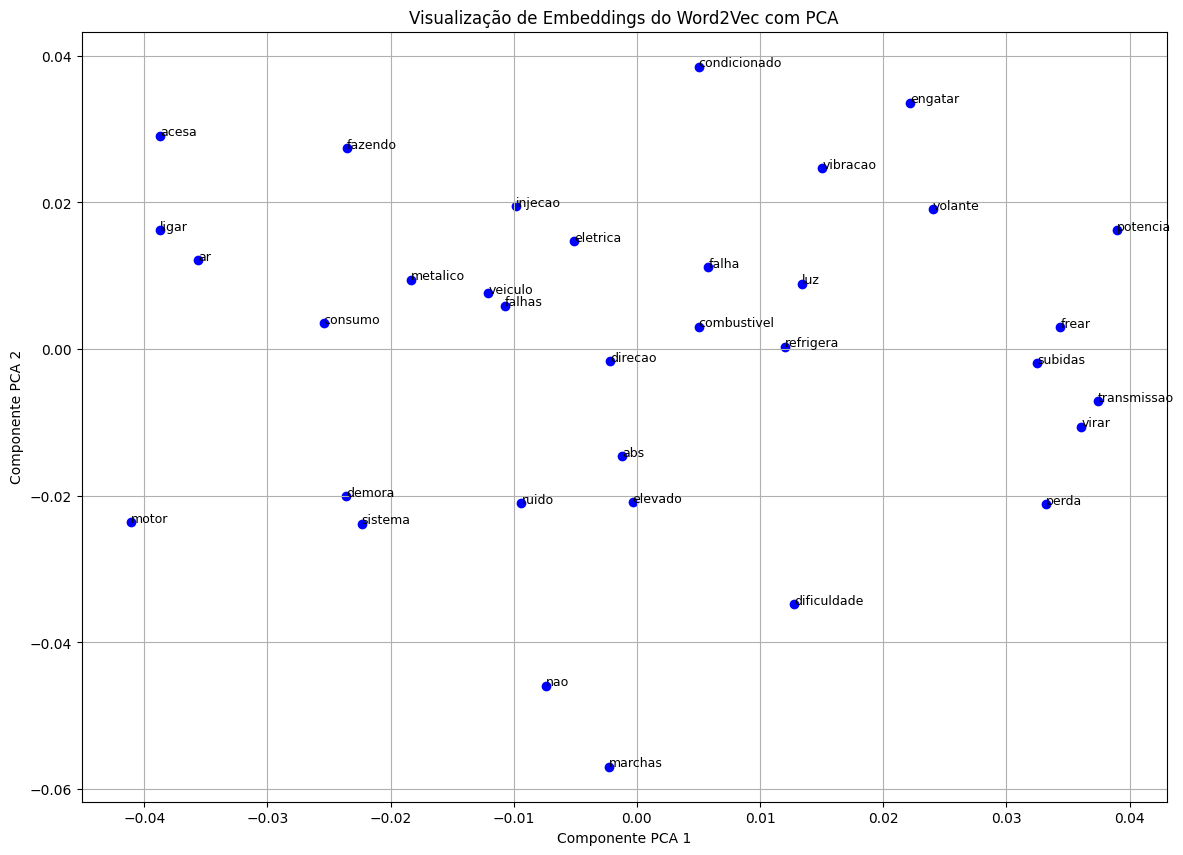

In [11]:
# Selecionar as palavras mais comuns e relacionadas ao contexto veicular para visualização
palavras = [word for word in model.wv.index_to_key if word.isalpha()][:100]  # Considera apenas palavras alfabéticas
word_vectors = model.wv[palavras]

# Reduzir a dimensionalidade para 2D usando PCA
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Criação do grafico para visualização
plt.figure(figsize=(14, 10))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], marker='o', color='blue')
for i, word in enumerate(palavras):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]), fontsize=9)
plt.title("Visualização de Embeddings do Word2Vec com PCA")
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.grid(True)
plt.show()


### **Função para Calcular a Média dos Vetores de Palavras**
Primeiro, criamos uma função que calcula o vetor médio de uma frase com base no modelo Word2Vec. Essa função será útil tanto para o conjunto de treino quanto para o de teste.

In [12]:
def get_average_vector(model, text):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

## **5. Avaliação do Modelo**

A função evaluate_model é utilizada para calcular a similaridade entre problemas de teste e treino, retornando os resultados.



In [13]:
def evaluate_model(test_problems_processed, train_problems_processed, train_df, model):
    results = []

    for test_problem in test_problems_processed:
        # Calcular o vetor médio para o problema de teste
        test_vector = get_average_vector(model, test_problem)

        # Calcular vetores médios dos problemas de treino
        train_vectors = [get_average_vector(model, problem) for problem in train_problems_processed]

        # Calcular similaridade coseno entre o problema de teste e todos os problemas de treino
        similarities = cosine_similarity([test_vector], train_vectors)[0]

        # Armazenar todos os resultados
        for idx, similarity in enumerate(similarities):
            most_similar_problem = train_df.iloc[idx]['Problema']
            results.append({
                'Categoria do Problema': train_df.iloc[idx]['Categoria do Problema'],
                'Problema de Teste': test_problem,
                'Problema Semelhante': most_similar_problem,
                'Similaridade': similarity  # Mantém o valor original de similaridade
            })

    # Ordenar os resultados por similaridade em ordem crescente
    sorted_results = sorted(results, key=lambda x: x['Similaridade'])

    # Retornar todos os resultados sem ordenação
    return sorted_results

In [14]:
# Avaliar modelo
all_results = evaluate_model(test_problems_processed, train_problems_processed, train_df, model)

In [15]:
# Transformar a lista de resultados em um DataFrame para facilitar a manipulação
results_df = pd.DataFrame(all_results)

# 1. Maior similaridade
max_similarity_result = results_df.loc[results_df['Similaridade'].idxmax()]

# 2. Menor similaridade
min_similarity_result = results_df.loc[results_df['Similaridade'].idxmin()]

# 3. Três resultados de cada intervalo
interval_results = {
    "0.2 - 0.4": results_df[(results_df['Similaridade'] >= 0.2) & (results_df['Similaridade'] < 0.4)].head(1),
    "0.4 - 0.6": results_df[(results_df['Similaridade'] >= 0.4) & (results_df['Similaridade'] < 0.6)].head(1),
    "0.6 - 0.8": results_df[(results_df['Similaridade'] >= 0.6) & (results_df['Similaridade'] < 0.8)].head(1),
}

# Imprimindo os resultados
print("Resultado com Maior Similaridade:")
print("Problema de Teste:", max_similarity_result['Problema de Teste'])
print("Problema Semelhante Encontrado:", max_similarity_result['Problema Semelhante'])
print("Similaridade:", f"{max_similarity_result['Similaridade']:.2f}")
print("-" * 50)


for interval, df in interval_results.items():
    print(f"Resultados no Intervalo ({interval}):")
    for _, row in df.iterrows():
        print("Problema de Teste:", row['Problema de Teste'])
        print("Problema Semelhante Encontrado:", row['Problema Semelhante'])
        print("Similaridade:", f"{row['Similaridade']:.2f}\n")

print("-" * 50)
print("Resultado com Menor Similaridade:")
print("Problema de Teste:", min_similarity_result['Problema de Teste'])
print("Problema Semelhante Encontrado:", min_similarity_result['Problema Semelhante'])
print("Similaridade:", f"{min_similarity_result['Similaridade']:.2f}")

Resultado com Maior Similaridade:
Problema de Teste: transmissao falhas
Problema Semelhante Encontrado: Transmissão com falhas
Similaridade: 1.00
--------------------------------------------------
Resultados no Intervalo (0.2 - 0.4):
Problema de Teste: luz abs acesa
Problema Semelhante Encontrado: Veículo demora a ligar
Similaridade: 0.20

Resultados no Intervalo (0.4 - 0.6):
Resultados no Intervalo (0.6 - 0.8):
Problema de Teste: luz abs acesa
Problema Semelhante Encontrado: Luz de injeção acesa
Similaridade: 0.76

--------------------------------------------------
Resultado com Menor Similaridade:
Problema de Teste: ruido virar volante
Problema Semelhante Encontrado: Veículo demora a ligar
Similaridade: -0.34


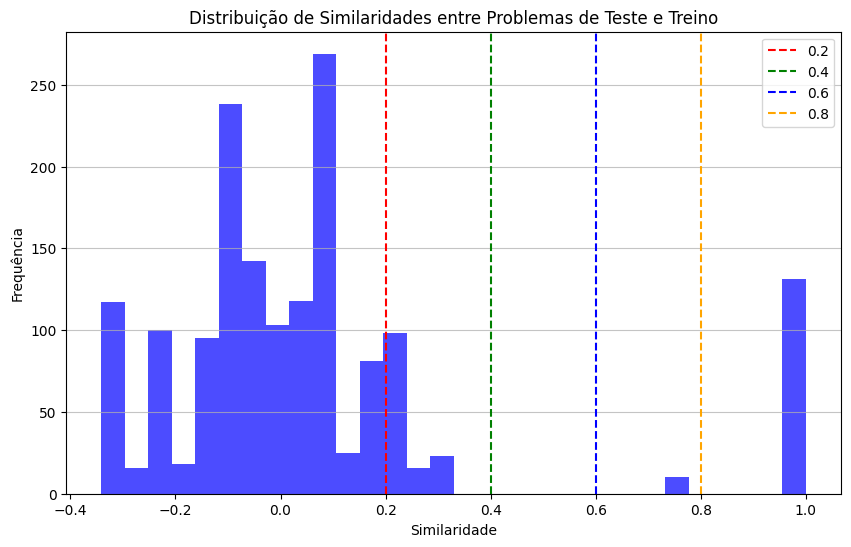

In [16]:
# Supondo que all_results é a lista de resultados com as similaridades
similarities = [result['Similaridade'] for result in all_results]

# Criar o histograma
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=30, color='blue', alpha=0.7)
plt.title('Distribuição de Similaridades entre Problemas de Teste e Treino')
plt.xlabel('Similaridade')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.axvline(x=0.2, color='r', linestyle='--', label='0.2')
plt.axvline(x=0.4, color='g', linestyle='--', label='0.4')
plt.axvline(x=0.6, color='b', linestyle='--', label='0.6')
plt.axvline(x=0.8, color='orange', linestyle='--', label='0.8')
plt.legend()
plt.show()


### **Teste com nova amostra**

test_model_with_new_sample é a função que testa o modelo Word2Vec com uma nova amostra e retorna o problema mais semelhante do conjunto de treino.

In [17]:
def test_model_with_new_sample(new_sample, train_problems_processed, train_df, model):
    # Pré-processar a nova amostra
    processed_sample = preprocess_text(new_sample)

    # Calcular o vetor médio para a nova amostra
    new_sample_vector = get_average_vector(model, processed_sample)

    # Calcular vetores médios dos problemas de treino
    train_vectors = [get_average_vector(model, problem) for problem in train_problems_processed]

    # Calcular similaridade coseno entre a nova amostra e todos os problemas de treino
    similarities = cosine_similarity([new_sample_vector], train_vectors)[0]

    # Encontrar o problema de treino mais semelhante à nova amostra
    max_similarity_idx = np.argmax(similarities)
    max_similarity = similarities[max_similarity_idx]
    most_similar_problem = train_df.iloc[max_similarity_idx]['Problema']

    # Exibir os resultados
    print("Nova Amostra:", new_sample)
    print("Problema Semelhante Encontrado:", most_similar_problem)
    print("Similaridade:", f"{max_similarity:.2f}")


In [18]:
# Testar o modelo com várias amostras
new_samples = [
    "Dificuldade para engatar a marcha",
    "Ruído ao frear",
    "Motor superaquecendo",
    "Veículo não liga",
    "Problema com a direção"
]

for sample in new_samples:
    print(f"Testando nova amostra: '{sample}'")
    test_model_with_new_sample(sample, train_problems_processed, train_df, model)
    print("-" * 50)


Testando nova amostra: 'Dificuldade para engatar a marcha'
Nova Amostra: Dificuldade para engatar a marcha
Problema Semelhante Encontrado: Dificuldade para engatar marchas
Similaridade: 0.82
--------------------------------------------------
Testando nova amostra: 'Ruído ao frear'
Nova Amostra: Ruído ao frear
Problema Semelhante Encontrado: Vibração ao frear
Similaridade: 0.56
--------------------------------------------------
Testando nova amostra: 'Motor superaquecendo'
Nova Amostra: Motor superaquecendo
Problema Semelhante Encontrado: Motor fazendo ruído metálico
Similaridade: 0.58
--------------------------------------------------
Testando nova amostra: 'Veículo não liga'
Nova Amostra: Veículo não liga
Problema Semelhante Encontrado: Ar condicionado não refrigera
Similaridade: 0.26
--------------------------------------------------
Testando nova amostra: 'Problema com a direção'
Nova Amostra: Problema com a direção
Problema Semelhante Encontrado: Falha no sistema de direção elétric

## **Conclusão**

Neste notebook, exploramos o uso do Word2Vec para diagnosticar problemas veiculares. O processo incluiu a carga e o pré-processamento de dados, a divisão em conjuntos de treino e teste, o treinamento do modelo e a avaliação de similaridade entre problemas. As visualizações criadas ajudaram a compreender melhor a distribuição das similaridades e a eficácia do modelo.

Os resultados indicaram que o modelo pode identificar problemas semelhantes, mas há espaço para melhorias, especialmente em relação à precisão das similaridades. Ajustes nos dados, no pré-processamento e nos hiperparâmetros do modelo podem ajudar a alcançar melhor desempenho em futuras implementações.

A utilização de Word2Vec demonstra-se eficaz em capturar a semântica dos problemas veiculares, oferecendo um caminho promissor para desenvolver sistemas de diagnóstico automotivo. Atingindo o objetivo do desenvolvimento do modelo previsto pela equipe.